# Spotify Premium Prediction

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Loading Dataset

In [2]:
# Load the datasets
file_path = "Spotify_data.xlsx"
file_path2 = "Spotify_data2.xlsx"
df1 = pd.read_excel(file_path)
df2 = pd.read_excel(file_path2)

# Combine the datasets
combined_df = pd.concat([df1, df2], ignore_index=True)

# Display
combined_df.head()

,Age,Gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,music_Influencial_mood,music_lis_frequency,music_expl_method,music_recc_rating,pod_lis_frequency,fav_pod_genre,preffered_pod_format,pod_host_preference,preffered_pod_duration,pod_variety_satisfaction
0,20-35,Female,More than 2 years,Smart speakers or voice assistants,Free (ad-supported),Yes,Family Plan-Rs 179/month,Podcast,Melody,Night,Sadness or melancholy,leisure time,Playlists,3,Daily,Comedy,Interview,Both,Both,Ok
1,12-20,Male,More than 2 years,Computer or laptop,Free (ad-supported),Yes,Individual Plan- Rs 119/ month,Podcast,Rap,Afternoon,Social gatherings or parties,Workout session,Playlists,2,Several times a week,Comedy,Interview,Both,NaN,Satisfied
2,35-60,Others,6 months to 1 year,Smart speakers or voice assistants,Free (ad-supported),Yes,Student Plan-Rs 59/month,Podcast,Pop,Night,Relaxation and stress relief,"Study Hours, While Traveling",Playlists,4,Once a week,Sports,Interview,NaN,Both,Satisfied
3,20-35,Female,1 year to 2 years,"Smartphone, Smart speakers or voice assistants",Free (ad-supported),No,NaN,Music,Melody,Night,"Relaxation and stress relief, Social gathering...","Office hours, Workout session, leisure time","recommendations, Playlists",4,Never,NaN,NaN,NaN,NaN,Ok
4,20-35,Female,1 year to 2 years,Smartphone,Free (ad-supported),No,NaN,Music,Melody,Night,Relaxation and stress relief,leisure time,"recommendations, Playlists",4,Rarely,Lifestyle and Health,Story telling,Well known individuals,Both,Ok


In [3]:
combined_df.shape

(600, 20)

## Persona Construction

In [4]:
# Define personas
premium_members = combined_df[combined_df['spotify_subscription_plan'] == 'Premium (paid subscription)']
free_members = combined_df[combined_df['spotify_subscription_plan'] == 'Free (ad-supported)']
free_members_willing_to_upgrade = combined_df[(combined_df['spotify_subscription_plan'] == 'Free (ad-supported)') & 
                                              (combined_df['premium_sub_willingness'] == 'Yes')]

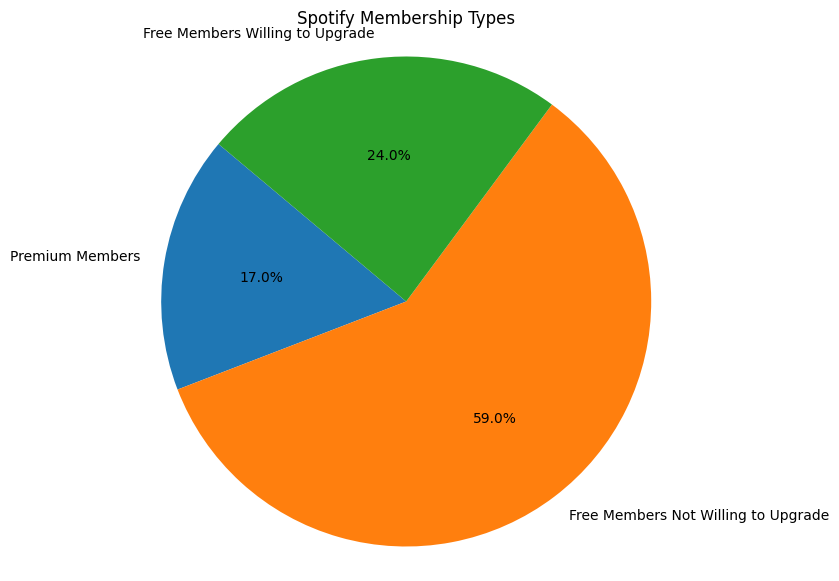

In [5]:
# Plotting a pie chart
sizes = [len(premium_members), len(free_members) - len(free_members_willing_to_upgrade), len(free_members_willing_to_upgrade)]
labels = ['Premium Members', 'Free Members Not Willing to Upgrade', 'Free Members Willing to Upgrade']

plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  
plt.title('Spotify Membership Distribution')
plt.show()

In [6]:
# Initialize a dictionary to hold the modes
premium_modes = {}

# Iterate through each column to calculate the mode
for column in premium_members.columns:
    if premium_members[column].dtype == 'object' or len(premium_members[column].unique()) < 10:
        mode_value = stats.mode(premium_members[column])[0][0]
        premium_modes[column] = mode_value

In [7]:
premium_modes

{'Age': '20-35',
 'Gender': 'Female',
 'spotify_usage_period': 'More than 2 years',
 'spotify_listening_device': 'Smartphone',
 'spotify_subscription_plan': 'Premium (paid subscription)',
 'premium_sub_willingness': 'Yes',
 'preffered_premium_plan': 'Individual Plan- Rs 119/ month',
 'preferred_listening_content': 'Music',
 'fav_music_genre': 'Melody',
 'music_time_slot': 'Night',
 'music_Influencial_mood': 'Relaxation and stress relief',
 'music_lis_frequency': 'While Traveling',
 'music_expl_method': 'Radio',
 'music_recc_rating': 3,
 'pod_lis_frequency': 'Rarely',
 'fav_pod_genre': 'Health and Fitness',
 'preffered_pod_format': 'Story telling',
 'pod_host_preference': 'Both',
 'preffered_pod_duration': 'Longer',
 'pod_variety_satisfaction': 'Ok'}

In [8]:
# Initialize a dictionary to hold the modes
free_modes = {}

# Iterate through each column to calculate the mode
for column in free_members.columns:
    if free_members[column].dtype == 'object' or len(free_members[column].unique()) < 10:
        mode_value = stats.mode(free_members[column])[0][0]
        free_modes[column] = mode_value

In [9]:
free_modes

{'Age': '20-35',
 'Gender': 'Female',
 'spotify_usage_period': 'More than 2 years',
 'spotify_listening_device': 'Smartphone',
 'spotify_subscription_plan': 'Free (ad-supported)',
 'premium_sub_willingness': 'No',
 'preffered_premium_plan': nan,
 'preferred_listening_content': 'Music',
 'fav_music_genre': 'Melody',
 'music_time_slot': 'Night',
 'music_Influencial_mood': 'Relaxation and stress relief',
 'music_lis_frequency': 'leisure time',
 'music_expl_method': 'Playlists',
 'music_recc_rating': 4,
 'pod_lis_frequency': 'Rarely',
 'fav_pod_genre': nan,
 'preffered_pod_format': nan,
 'pod_host_preference': nan,
 'preffered_pod_duration': 'Shorter',
 'pod_variety_satisfaction': 'Ok'}

In [10]:
# Initialize a dictionary to hold the modes
upgrade_modes = {}

# Iterate through each column to calculate the mode
for column in free_members_willing_to_upgrade.columns:
    mode_series = free_members_willing_to_upgrade[column].mode()
    if not mode_series.empty:  # Check if the mode could be computed
        upgrade_modes[column] = mode_series[0]

In [11]:
upgrade_modes

{'Age': '20-35',
 'Gender': 'Female',
 'spotify_usage_period': 'More than 2 years',
 'spotify_listening_device': 'Smartphone',
 'spotify_subscription_plan': 'Free (ad-supported)',
 'premium_sub_willingness': 'Yes',
 'preffered_premium_plan': 'Individual Plan- Rs 119/ month',
 'preferred_listening_content': 'Music',
 'fav_music_genre': 'Melody',
 'music_time_slot': 'Night',
 'music_Influencial_mood': 'Relaxation and stress relief',
 'music_lis_frequency': 'While Traveling',
 'music_expl_method': 'recommendations, Playlists',
 'music_recc_rating': 3,
 'pod_lis_frequency': 'Rarely',
 'fav_pod_genre': 'Lifestyle and Health',
 'preffered_pod_format': 'Story telling',
 'pod_host_preference': 'Both',
 'preffered_pod_duration': 'Shorter',
 'pod_variety_satisfaction': 'Ok'}

## Variable Convertion

#### Converting X categorical variables into dummy

In [12]:
combined_df.dtypes

Age                            object
Gender                         object
spotify_usage_period           object
spotify_listening_device       object
spotify_subscription_plan      object
premium_sub_willingness        object
preffered_premium_plan         object
preferred_listening_content    object
fav_music_genre                object
music_time_slot                object
music_Influencial_mood         object
music_lis_frequency            object
music_expl_method              object
music_recc_rating               int64
pod_lis_frequency              object
fav_pod_genre                  object
preffered_pod_format           object
pod_host_preference            object
preffered_pod_duration         object
pod_variety_satisfaction       object
dtype: object

In [13]:
# change variables name to ensure mapping accurately
combined_df.rename(columns={'spotify_usage_period': 'usage_period', 
                                          'spotify_listening_device': 'device',
                                         'preffered_premium_plan': 'premium_plan',
                                         'preferred_listening_content': 'listening_content',
                                         'music_time_slot': 'time_slot',
                                         'music_Influencial_mood': 'Influencial_mood',
                                         'music_lis_frequency': 'lis_frequency',
                                         'music_expl_method': 'expl_method',
                                        'music_recc_rating': 'recc_rating',
                                         'fav_music_genre': 'music_genre',
                                         'preffered_pod_format': 'format',
                                         'pod_host_preference': 'host_preference',
                           'pod_variety_satisfaction': 'variety_satisfaction'}, inplace=True)

In [14]:
# Use all other variables to predict membership upgrade willingness
X = combined_df.drop('premium_sub_willingness', axis=1)
y = combined_df['premium_sub_willingness']

In [15]:
X.dtypes

Age                          object
Gender                       object
usage_period                 object
device                       object
spotify_subscription_plan    object
premium_plan                 object
listening_content            object
music_genre                  object
time_slot                    object
Influencial_mood             object
lis_frequency                object
expl_method                  object
recc_rating                   int64
pod_lis_frequency            object
fav_pod_genre                object
format                       object
host_preference              object
preffered_pod_duration       object
variety_satisfaction         object
dtype: object

In [16]:
# define all catgorical columns and put into a list
categorical_columns = ['Age', 'Gender', 'usage_period', 'device', 'spotify_subscription_plan'
                       ,'premium_plan',
                       'listening_content', 'music_genre', 'time_slot', 
                       'Influencial_mood', 'lis_frequency', 'expl_method', 
                        'pod_lis_frequency', 'fav_pod_genre', 
                       'format', 'host_preference', 'preffered_pod_duration', 
                       'variety_satisfaction']

In [17]:
# OneHotEncoder to convert X into dummy
encoder = OneHotEncoder(sparse=False, drop='first')
X_encoded = encoder.fit_transform(X[categorical_columns])  
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_columns))

In [18]:
X_new = pd.concat([X_encoded_df, pd.DataFrame(combined_df['recc_rating'])], axis=1)
X_new

,Age_20-35,Age_35-60,Age_6-12,Age_60+,Gender_Male,Gender_Others,usage_period_6 months to 1 year,usage_period_Less than 6 months,usage_period_More than 2 years,"device_Computer or laptop, Smart speakers or voice assistants",...,host_preference_unknown Podcasters,host_preference_nan,preffered_pod_duration_Longer,preffered_pod_duration_Shorter,preffered_pod_duration_nan,variety_satisfaction_Ok,variety_satisfaction_Satisfied,variety_satisfaction_Very Dissatisfied,variety_satisfaction_Very Satisfied,recc_rating
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2
2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5
596,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5
597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5
598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3


#### Converting Y into binary

In [19]:
# Convert Y into binary values
target = 'premium_sub_willingness'
label_encoder = LabelEncoder()
y_new = label_encoder.fit_transform(combined_df[target])

In [20]:
# Display new Y column
y_new = pd.DataFrame(y_new, columns=['premium_sub_willingness'])
y_new

,premium_sub_willingness
0,1
1,1
2,1
3,0
4,0
...,...
595,1
596,0
597,0
598,1


## Modeling

In [21]:
# split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)
log_reg = LogisticRegression(max_iter=1000)

#### Hyperparameter Tunning

In [22]:
# Grid_search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver':  ['saga']
}

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1)

In [23]:
# find the best parameter through GridsearchCV
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}


In [24]:
# Use the best model and show the main metrics
logistic_model = grid_search.best_estimator_
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8417
              precision    recall  f1-score   support

           0       0.88      0.87      0.87        76
           1       0.78      0.80      0.79        44

    accuracy                           0.84       120
   macro avg       0.83      0.83      0.83       120
weighted avg       0.84      0.84      0.84       120



In [25]:
# check intercept
intercept = logistic_model.intercept_[0]
intercept

-0.26353633603707294

In [26]:
# check coefficients of all X variables
coefficients = logistic_model.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_new.columns, 'Coefficient': coefficients})
feature_importance

,Feature,Coefficient
0,Age_20-35,-0.036643
1,Age_35-60,-0.214844
2,Age_6-12,-0.038718
3,Age_60+,-0.034114
4,Gender_Male,0.026043
...,...,...
144,variety_satisfaction_Ok,-0.281954
145,variety_satisfaction_Satisfied,-0.025224
146,variety_satisfaction_Very Dissatisfied,-0.015292
147,variety_satisfaction_Very Satisfied,0.252834


In [27]:
# Initialize an empty dictionary to store DataFrames for each unique prefix
dfs = {}

# Iterate over each row in the feature_importance DataFrame
for _, row in feature_importance.iterrows():
    prefix = row['Feature'].split('_', 1)[0]
    if prefix not in dfs:
        dfs[prefix] = pd.DataFrame(columns=feature_importance.columns)    
    dfs[prefix] = pd.concat([dfs[prefix], pd.DataFrame([row])], ignore_index=True)

In [28]:
# Split the 'Feature' names on the underscore and retain the prefix for each feature
feature_importance['Feature'].apply(lambda x: x.split('_')[0])

0          Age
1          Age
2          Age
3          Age
4       Gender
        ...   
144    variety
145    variety
146    variety
147    variety
148       recc
Name: Feature, Length: 149, dtype: object

In [29]:
# Add a new column 'OriginalFeature' to store the prefix of each feature name
feature_importance['OriginalFeature'] = feature_importance['Feature'].apply(lambda x: x.split('_')[0])

# Group the features by the 'OriginalFeature' column and sum the absolute values of their coefficients
original_feature_importance = feature_importance.groupby('OriginalFeature')['Coefficient'].apply(lambda x: x.abs().sum()).reset_index()

# Sort the resulting DataFrame by the summed absolute coefficients in descending order
original_feature_importance = original_feature_importance.sort_values(by='Coefficient', ascending=False)

In [30]:
# print absolute accumulated feature importance of each feature
original_feature_importance

,OriginalFeature,Coefficient
13,premium,3.032183
8,lis,2.332438
2,Influencial,1.770995
4,expl,1.410340
3,device,1.085498
5,fav,0.821933
15,spotify,0.787444
10,music,0.683273
18,variety,0.575303
11,pod,0.407839


* Age = Age
* Gender = Gender
* usage = spotify_usage_period
* device = spotify_listening_device
* spotify = spotify_subscription_plan
* premium = preffered_premium_plan
* listening = preferred_listening_content
* music = fav_music_genre
* time = music_time_slot
* Influencial = music_Influencial_mood
* lis = music_lis_frequency
* expl = music_expl_method
* recc = music_recc_rating
* pod = pod_lis_frequency
* fav = fav_pod_genre
* format = preffered_pod_format
* host = pod_host_preference
* preffered = preffered_pod_duration
* variety = pod_variety_satisfaction

In [31]:
# an empty dictionary to store dataframes
dfs = {}

# Iterate over each row in the feature_importance DataFrame
for _, row in feature_importance.iterrows():
     # Extract the category prefix from the 'Feature' column by splitting the string at the first underscore
    prefix = row['Feature'].split('_', 1)[0]
    if prefix not in dfs:
        dfs[prefix] = pd.DataFrame(columns=feature_importance.columns)
    # Append the current row to the DataFrame corresponding to its category prefix
    dfs[prefix] = pd.concat([dfs[prefix], pd.DataFrame([row])], ignore_index=True)

In [32]:
# print coefficients for age at different levels
dfs['Age']

,Feature,Coefficient,OriginalFeature
0,Age_20-35,-0.036643,Age
1,Age_35-60,-0.214844,Age
2,Age_6-12,-0.038718,Age
3,Age_60+,-0.034114,Age


In [33]:
# print coefficients for gender at different levels
dfs['Gender']

,Feature,Coefficient,OriginalFeature
0,Gender_Male,0.026043,Gender
1,Gender_Others,-0.008891,Gender


In [34]:
# print coefficients for usage period at different levels
dfs['usage']

,Feature,Coefficient,OriginalFeature
0,usage_period_6 months to 1 year,0.152635,usage
1,usage_period_Less than 6 months,-0.120914,usage
2,usage_period_More than 2 years,0.110583,usage


In [35]:
# print coefficients for device types at different levels
dfs['device']

,Feature,Coefficient,OriginalFeature
0,"device_Computer or laptop, Smart speakers or v...",0.072902,device
1,"device_Computer or laptop, Smart speakers or v...",-0.052286,device
2,"device_Computer or laptop, Wearable devices",0.049361,device
3,device_Smart speakers or voice assistants,0.176671,device
4,"device_Smart speakers or voice assistants, Wea...",0.022537,device
5,device_Smartphone,-0.346797,device
6,"device_Smartphone, Computer or laptop",0.037708,device
7,"device_Smartphone, Computer or laptop, Smart s...",0.045004,device
8,"device_Smartphone, Computer or laptop, Smart s...",0.031352,device
9,"device_Smartphone, Computer or laptop, Wearabl...",0.022840,device


In [36]:
# print coefficients for subscription at different levels
dfs['spotify']

,Feature,Coefficient,OriginalFeature
0,spotify_subscription_plan_Premium,0.154422,spotify
1,spotify_subscription_plan_Premium (paid subscr...,0.633023,spotify


In [37]:
# print coefficients for premium plan types at different levels
dfs['premium']

,Feature,Coefficient,OriginalFeature
0,premium_plan_Family Plan-Rs 179/month,0.363648,premium
1,premium_plan_Individual Plan- Rs 119/ month,0.902827,premium
2,premium_plan_Student Plan-Rs 59/month,0.045413,premium
3,premium_plan_nan,-1.720295,premium


In [38]:
# print coefficients for podcast content
dfs['listening']

,Feature,Coefficient,OriginalFeature
0,listening_content_Podcast,0.380485,listening


In [39]:
# print coefficients for time when listening at different levels
dfs['time']

,Feature,Coefficient,OriginalFeature
0,time_slot_Evening,0.112570,time
1,time_slot_Morning,-0.112497,time
2,time_slot_Night,-0.086250,time


In [40]:
# print coefficients for moods at different levels
dfs['Influencial']

,Feature,Coefficient,OriginalFeature
0,"Influencial_mood_Relaxation and stress relief,...",0.263912,Influencial
1,"Influencial_mood_Relaxation and stress relief,...",0.093015,Influencial
2,"Influencial_mood_Relaxation and stress relief,...",-0.103187,Influencial
3,"Influencial_mood_Relaxation and stress relief,...",0.002998,Influencial
4,"Influencial_mood_Relaxation and stress relief,...",-0.097671,Influencial
5,"Influencial_mood_Relaxation and stress relief,...",-0.060571,Influencial
6,"Influencial_mood_Relaxation and stress relief,...",-0.118707,Influencial
7,Influencial_mood_Sadness or melancholy,0.346729,Influencial
8,"Influencial_mood_Sadness or melancholy, Social...",0.015365,Influencial
9,Influencial_mood_Social gatherings or parties,-0.201504,Influencial


In [41]:
# print coefficients for listening behavior at different levels
dfs['lis']

,Feature,Coefficient,OriginalFeature
0,"lis_frequency_Office hours, Study Hours, While...",0.093535,lis
1,"lis_frequency_Office hours, Study Hours, While...",-0.045674,lis
2,"lis_frequency_Office hours, Study Hours, While...",0.113808,lis
3,"lis_frequency_Office hours, Study Hours, While...",0.030654,lis
4,"lis_frequency_Office hours, Study Hours, While...",-0.054960,lis
5,"lis_frequency_Office hours, Study Hours, Worko...",-0.010215,lis
6,"lis_frequency_Office hours, While Traveling",-0.055792,lis
7,"lis_frequency_Office hours, While Traveling,",-0.041045,lis
8,"lis_frequency_Office hours, While Traveling, W...",-0.027291,lis
9,"lis_frequency_Office hours, While Traveling, W...",-0.014312,lis


In [42]:
# print coefficients for method of exploring at different levels
dfs['expl']

,Feature,Coefficient,OriginalFeature
0,"expl_method_Others, Friends",-0.043631,expl
1,"expl_method_Others, Search",0.058737,expl
2,"expl_method_Others, Social media",-0.024181,expl
3,expl_method_Playlists,-0.108112,expl
4,"expl_method_Playlists, Others",0.060403,expl
5,"expl_method_Playlists, Radio",0.069781,expl
6,"expl_method_Playlists, Radio, Others",-0.057508,expl
7,expl_method_Radio,-0.052956,expl
8,"expl_method_Radio, Others",0.088571,expl
9,expl_method_recommendations,-0.187368,expl


In [43]:
# print coefficients for recommendation score at different levels
dfs['recc']

,Feature,Coefficient,OriginalFeature
0,recc_rating,0.049544,recc


In [44]:
# print coefficients for podcast listening frequency at different levels
dfs['pod']

,Feature,Coefficient,OriginalFeature
0,pod_lis_frequency_Never,-0.011977,pod
1,pod_lis_frequency_Once a week,0.190239,pod
2,pod_lis_frequency_Rarely,0.036335,pod
3,pod_lis_frequency_Several times a week,-0.169288,pod


In [45]:
# print coefficients for podcast contents at different levels
dfs['format']

,Feature,Coefficient,OriginalFeature
0,format_Educational,0.247737,format
1,format_Interview,-0.024144,format
2,format_Story telling,0.022778,format
3,format_nan,0.047530,format


In [46]:
# print coefficients for podcast host preference at different levels
dfs['host']

,Feature,Coefficient,OriginalFeature
0,host_preference_Well known individuals,-0.032427,host
1,host_preference_unknown Podcasters,-0.051465,host
2,host_preference_nan,-0.009021,host


In [47]:
# print coefficients for podcast length preference at different levels
dfs['preffered']

,Feature,Coefficient,OriginalFeature
0,preffered_pod_duration_Longer,0.170356,preffered
1,preffered_pod_duration_Shorter,-0.106634,preffered
2,preffered_pod_duration_nan,-0.049450,preffered


In [48]:
# print coefficients for satisfaction at different levels
dfs['variety']

,Feature,Coefficient,OriginalFeature
0,variety_satisfaction_Ok,-0.281954,variety
1,variety_satisfaction_Satisfied,-0.025224,variety
2,variety_satisfaction_Very Dissatisfied,-0.015292,variety
3,variety_satisfaction_Very Satisfied,0.252834,variety
